## Emotion detection on WFH tweets


In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tweepy as tw
import re
from bs4 import BeautifulSoup
import unicodedata

In [37]:
my_api_key="PmEkXvD5SOzKrSr4qvvqMXvk9"
my_api_secret="C4JS9AJFUGisjV41aUAjswqNAqQEiOzxjMhie7nFzavkSVKdCi"
access_token="1311021656018620416-R5pzKxByMievd2NgedZKoiIc9mZVay"
access_token_secret= "MK7uwP5ny0sKL7ASWnckTID37f5vqfVPYCYzmEVRKec4N"

In [38]:
auth = tw.OAuthHandler(my_api_key, my_api_secret)
auth.set_access_token(access_token, access_token_secret)
api = tw.API(auth, wait_on_rate_limit=True)

In [39]:
hashtags = ['#WFH', '#WorkFromHome']
user_id = []
created_at = []
text = []

In [40]:
for hashtag in hashtags:
    tweets = tw.Cursor(api.search_tweets, q=hashtag+" -filter:retweets", lang="en").items(50000)
    for tweet in tweets:
        user_id.append(tweet.user.id)
        created_at.append(tweet.created_at)
        text.append(tweet.text)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\bnite\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3444, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\bnite\AppData\Local\Temp/ipykernel_22428/3147811022.py", line 3, in <module>
    for tweet in tweets:
  File "C:\Users\bnite\anaconda3\lib\site-packages\tweepy\cursor.py", line 86, in __next__
    return self.next()
  File "C:\Users\bnite\anaconda3\lib\site-packages\tweepy\cursor.py", line 286, in next
    self.current_page = next(self.page_iterator)
  File "C:\Users\bnite\anaconda3\lib\site-packages\tweepy\cursor.py", line 86, in __next__
    return self.next()
  File "C:\Users\bnite\anaconda3\lib\site-packages\tweepy\cursor.py", line 167, in next
    data = self.method(max_id=self.max_id, parser=RawParser(), *self.args, **self.kwargs)
  File "C:\Users\bnite\anaconda3\lib\site-packages\tweepy\api.py", line 33, in wrapper
    return method(*args, **kwargs)
  File "C:\Users\b

TypeError: object of type 'NoneType' has no len()

In [125]:
wfh_df = pd.DataFrame({"created_at": created_at, "user_id": user_id, "text": text})
wfh_df.to_csv('wfh_tweets.csv')

NameError: name 'created_at' is not defined

In [270]:
wfh_df = pd.read_csv('wfh_tweets.csv')
wfh_df.drop(columns='Unnamed: 0', axis=1, inplace=True)

In [271]:
len(wfh_df)

10363

In [272]:
wfh_df.head()

,created_at,user_id,text
0,2022-07-26 20:03:14+00:00,16117160,Saw this @WSJ article on remote work coinciden...
1,2022-07-26 20:01:20+00:00,4440814155,Much of the discussion surrounding the office ...
2,2022-07-26 19:57:28+00:00,2176790760,New Remote Customer Support Job! Stock&amp;Buy...
3,2022-07-26 19:56:55+00:00,229540362,The most recommended #WFH tips from remote emp...
4,2022-07-26 19:47:38+00:00,2176790760,New Remote Management and Finance Job! Cloudli...


In [273]:
wfh_df['text'][1]

'Much of the discussion surrounding the office sector has focused on work-from-home #WFH policies driving employees… https://t.co/zDMjq23dmu'

### Pre-processing

In [274]:
def remove_punctuation_func(text):
    return re.sub(r'[^a-zA-Z0-9]', ' ', text)

def remove_numbers(text):
    return re.sub(r'[0-9]', ' ', text)

def remove_html_tags_func(text):
    return BeautifulSoup(text, 'html.parser').get_text()

def remove_url_func(text):
    return re.sub(r'https?://\S+|www\.\S+', '', text)

def remove_accented_chars_func(text):
    return unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')

def remove_extra_whitespaces_func(text):
    return re.sub(r'^\s*|\s\s*', ' ', text).strip()

In [275]:
def pre_processing(dataset):
    #drop duplicates
    dataset.drop_duplicates(inplace=True)
    
    #convert to lowercase
    dataset["text"] = dataset["text"].str.lower()
    
        
    #remove URLs
    dataset["text"] = dataset["text"].apply(remove_url_func)

    #remove punctuations
    dataset["text"] = dataset["text"].apply(remove_punctuation_func)

    #remove numbers
    dataset["text"] = dataset["text"].apply(remove_numbers)
    
    #remove html tags
    dataset["text"] = dataset["text"].apply(remove_html_tags_func)

    
    #remove accented characters
    dataset["text"] = dataset["text"].apply(remove_accented_chars_func)
    
    #remove extra whitespaces
    dataset["text"] = dataset["text"].apply(remove_extra_whitespaces_func)
    
    #drop duplicates
    dataset.drop_duplicates(inplace=True)

In [276]:
pre_processing(wfh_df)

In [277]:
wfh_df.head()

,created_at,user_id,text
0,2022-07-26 20:03:14+00:00,16117160,saw this wsj article on remote work coincident...
1,2022-07-26 20:01:20+00:00,4440814155,much of the discussion surrounding the office ...
2,2022-07-26 19:57:28+00:00,2176790760,new remote customer support job stock amp buy ...
3,2022-07-26 19:56:55+00:00,229540362,the most recommended wfh tips from remote empl...
4,2022-07-26 19:47:38+00:00,2176790760,new remote management and finance job cloudlin...


In [278]:
wfh_df['text'][1]

'much of the discussion surrounding the office sector has focused on work from home wfh policies driving employees'

### Sentiment Analysis

In [154]:
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [155]:
positive  = 0
negative = 0
neutral = 0
tweet_list = []
neutral_list = []
negative_list = []
positive_list = []

In [156]:
for tweet in wfh_df['text']:
    tweet_list.append(tweet)
    score = SentimentIntensityAnalyzer().polarity_scores(tweet)
    neg = score['neg']
    neu = score['neu']
    pos = score['pos']
    comp = score['compound']
    
    if neg > pos:
        negative_list.append(tweet)
        negative += 1 
    elif pos > neg:
        positive_list.append(tweet)
        positive += 1
    elif pos == neg:
        neutral_list.append(tweet)
        neutral += 1

In [157]:
positive = round(100 * (float(positive)/float(len(wfh_df))) , 2)
negative = round(100 * float(negative)/float(len(wfh_df)) , 2)
neutral = round(100 * float(neutral)/float(len(wfh_df)) , 2)

In [158]:
positive

49.04

In [159]:
#Number of Tweets (Total, Positive, Negative, Neutral)
tweet_list = pd.DataFrame(tweet_list)
neutral_list = pd.DataFrame(neutral_list)
negative_list = pd.DataFrame(negative_list)
positive_list = pd.DataFrame(positive_list)
print("total number: ",len(tweet_list))
print("positive number: ",len(positive_list))
print("negative number: ", len(negative_list))
print("neutral number: ",len(neutral_list))

total number:  9917
positive number:  4863
negative number:  746
neutral number:  4308


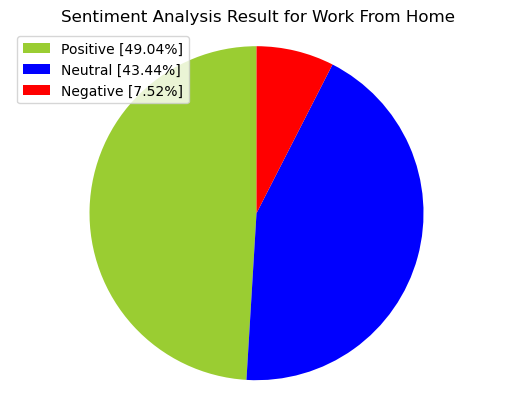

In [160]:
#Creating PieCart

labels = ['Positive ['+str(positive)+'%]' , 'Neutral ['+str(neutral)+'%]','Negative ['+str(negative)+'%]']
sizes = [positive, neutral, negative]
colors = ['yellowgreen', 'blue','red']
patches, texts = plt.pie(sizes,colors=colors, startangle=90)
plt.style.use('default')
plt.legend(labels)
plt.title("Sentiment Analysis Result for Work From Home" )
plt.axis('equal')
plt.show()

In [161]:
len(tweet_list)

9917

In [164]:
tw_list = pd.DataFrame(tweet_list)
tw_list.rename(columns={0:'text'}, inplace=True)
tw_list

,text
0,saw this wsj article on remote work coincident...
1,much of the discussion surrounding the office ...
2,new remote customer support job stock amp buy ...
3,the most recommended wfh tips from remote empl...
4,new remote management and finance job cloudlin...
...,...
9912,new remote job content writer iii remotejobs r...
9913,online captcha solving jobs list of legitimate...
9914,looking for participants for an approximately ...
9915,usually marketing courses are costly mine is t...


In [165]:
#Calculating Negative, Positive, Neutral and Compound values
for index, row in tw_list['text'].iteritems():
    score = SentimentIntensityAnalyzer().polarity_scores(row)
    neg = score['neg']
    neu = score['neu']
    pos = score['pos']
    comp = score['compound']
    if neg > pos:
        tw_list.loc[index, 'sentiment'] = "negative"
    elif pos > neg:
        tw_list.loc[index, 'sentiment'] = "positive"
    else:
        tw_list.loc[index, 'sentiment'] = "neutral"
    tw_list.loc[index, 'neg'] = neg
    tw_list.loc[index, 'neu'] = neu
    tw_list.loc[index, 'pos'] = pos
    tw_list.loc[index, 'compound'] = comp

tw_list.head()

,text,sentiment,neg,neu,pos,compound
0,saw this wsj article on remote work coincident...,neutral,0.0,1.000,0.000,0.0000
1,much of the discussion surrounding the office ...,positive,0.0,0.867,0.133,0.3818
2,new remote customer support job stock amp buy ...,positive,0.0,0.690,0.310,0.6597
3,the most recommended wfh tips from remote empl...,positive,0.0,0.770,0.230,0.2716
4,new remote management and finance job cloudlin...,neutral,0.0,1.000,0.000,0.0000


In [166]:
#Creating new data frames for all sentiments (positive, negative and neutral)
tw_list_negative = tw_list[tw_list["sentiment"]=="negative"]
tw_list_positive = tw_list[tw_list["sentiment"]=="positive"]
tw_list_neutral = tw_list[tw_list["sentiment"]=="neutral"]

In [167]:
def count_values_in_column(data,feature):
    total=data.loc[:,feature].value_counts(dropna=False)
    percentage=round(data.loc[:,feature].value_counts(dropna=False,normalize=True)*100,2)
    return pd.concat([total,percentage],axis=1,keys=['Total','Percentage'])
#Count_values for sentiment
count_values_in_column(tw_list,"sentiment")

,Total,Percentage
positive,4863,49.04
neutral,4308,43.44
negative,746,7.52


In [168]:
#Function to Create Wordcloud
def create_wordcloud(text):
    stopwords = set(STOPWORDS)
    wc = WordCloud(background_color='white', max_words=3000, stopwords=stopwords, repeat=True)
    wc.generate(str(text))
    wc.to_file('wc.png')
    path = 'wc.png'
    display(Image.open(path))

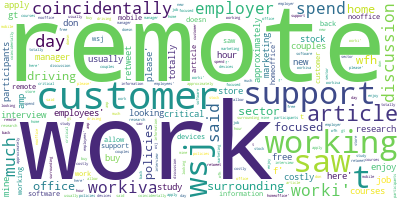

In [169]:
#Creating wordcloud for all tweets
create_wordcloud(tw_list['text'].values)

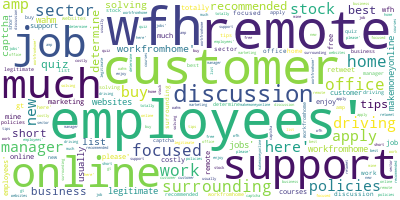

In [170]:
#Creating wordcloud for all positive tweets
create_wordcloud(tw_list_positive['text'].values)

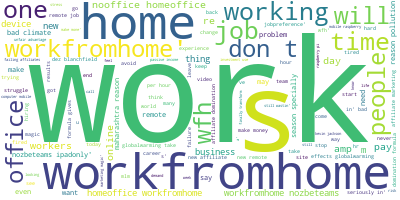

In [171]:
#Creating wordcloud for all negative tweets
create_wordcloud(tw_list_negative['text'].values)

## Emotion Detection

In [250]:
import nlp
dataset = nlp.load_dataset('emotion')

Using custom data configuration default


In [251]:
train = dataset['train']
val = dataset['validation']
test = dataset['test']

In [252]:
def get_tweets(data):
    tweets = [x['text'] for x in data]
    labels = [x['label'] for x in data]
    return tweets, labels

In [253]:
tweets, labels = get_tweets(train)

In [254]:
tweets[10], labels[10]

('i feel like i have to make the suffering i m seeing mean something',
 'sadness')

In [285]:
tweets[:10]

['i didnt feel humiliated',
 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
 'im grabbing a minute to post i feel greedy wrong',
 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
 'i am feeling grouchy',
 'ive been feeling a little burdened lately wasnt sure why that was',
 'ive been taking or milligrams or times recommended amount and ive fallen asleep a lot faster but i also feel like so funny',
 'i feel as confused about life as a teenager or as jaded as a year old man',
 'i have been with petronas for years i feel that petronas has performed well and made a huge profit',
 'i feel romantic too']

### Pre-processing the dataset

In [255]:
def get_sequences(tokenizer, tweets):
    sequences = tokenizer.texts_to_sequences(tweets)
    padded_sequences = pad_sequences(sequences, truncating='post', maxlen=60, padding='post')
    return padded_sequences

In [256]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')
tokenizer.fit_on_texts(tweets)

lengths = [len(t.split(' ')) for t in tweets]
padded_train_sequences = get_sequences(tokenizer, tweets)
classes = set(labels)
print(classes)

{'surprise', 'love', 'anger', 'sadness', 'joy', 'fear'}


In [286]:
tweets[10]

'i feel like i have to make the suffering i m seeing mean something'

In [281]:
padded_train_sequences[10]

array([  2,   3,  14,   2,  21,   5,  80,   6, 733,   2,  93, 544, 304,
        84,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0])

In [279]:
classes

{'anger', 'fear', 'joy', 'love', 'sadness', 'surprise'}

In [257]:
classes_to_index = dict((c, i) for i, c in enumerate(classes))
classes_to_index

{'surprise': 0, 'love': 1, 'anger': 2, 'sadness': 3, 'joy': 4, 'fear': 5}

In [258]:
index_to_classes = dict((v, k) for k, v in classes_to_index.items())
index_to_classes

{0: 'surprise', 1: 'love', 2: 'anger', 3: 'sadness', 4: 'joy', 5: 'fear'}

In [259]:
names_to_ids = lambda labels: np.array([classes_to_index.get(x) for x in labels])
train_labels = names_to_ids(labels)

### Creating the model

In [260]:
import tensorflow as tf
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(10000, 16, input_length=60),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 60, 16)            160000    
                                                                 
 bidirectional_12 (Bidirecti  (None, 60, 40)           5920      
 onal)                                                           
                                                                 
 bidirectional_13 (Bidirecti  (None, 40)               9760      
 onal)                                                           
                                                                 
 dense_6 (Dense)             (None, 6)                 246       
                                                                 
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


### Training the model

In [261]:
val_tweets, val_labels = get_tweets(val)
val_sequences = get_sequences(tokenizer, val_tweets)
val_labels = names_to_ids(val_labels)

In [262]:
h = model.fit(
    padded_train_sequences, train_labels,
    validation_data=(val_sequences, val_labels),
    epochs=15,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)

Epoch 1/15
500/500 [==============================] - 18s 28ms/step - loss: 1.2603 - accuracy: 0.5035 - val_loss: 0.7507 - val_accuracy: 0.7420
Epoch 2/15
500/500 [==============================] - 12s 24ms/step - loss: 0.5288 - accuracy: 0.8104 - val_loss: 0.6182 - val_accuracy: 0.8000
Epoch 3/15
500/500 [==============================] - 14s 27ms/step - loss: 0.3242 - accuracy: 0.8965 - val_loss: 0.4890 - val_accuracy: 0.8480
Epoch 4/15
500/500 [==============================] - 15s 30ms/step - loss: 0.2303 - accuracy: 0.9261 - val_loss: 0.5073 - val_accuracy: 0.8440
Epoch 5/15
500/500 [==============================] - 15s 30ms/step - loss: 0.1840 - accuracy: 0.9407 - val_loss: 0.4612 - val_accuracy: 0.8625
Epoch 6/15
500/500 [==============================] - 15s 31ms/step - loss: 0.1527 - accuracy: 0.9527 - val_loss: 0.4458 - val_accuracy: 0.8740
Epoch 7/15
500/500 [==============================] - 15s 31ms/step - loss: 0.1227 - accuracy: 0.9611 - val_loss: 0.4505 - val_accuracy:

### Evaluating the model

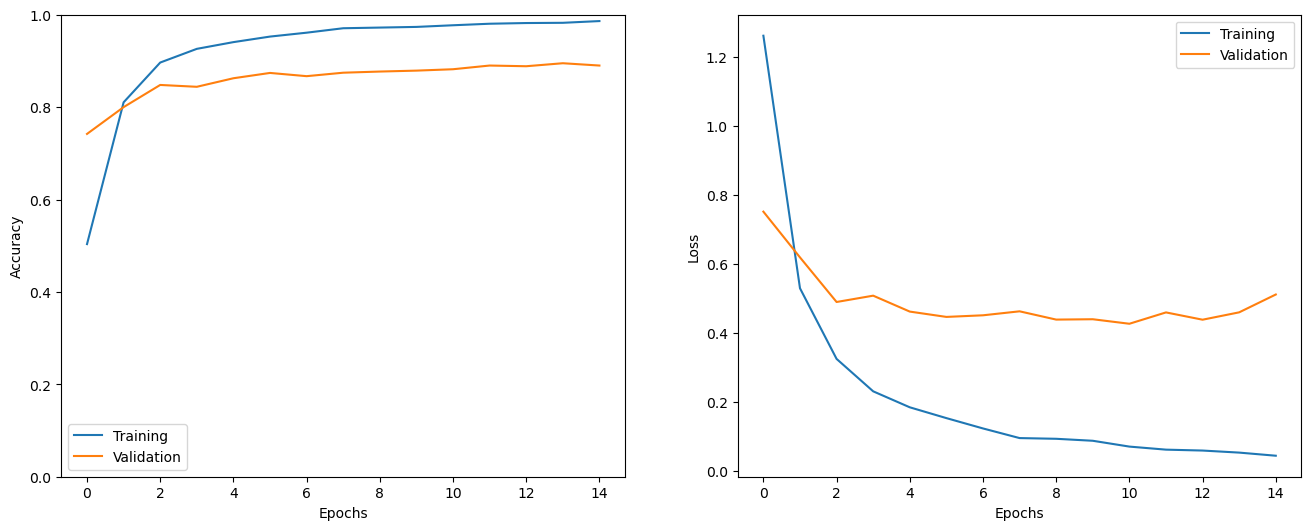

In [263]:
def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

show_history(h)

### Tokenizing the wfh tweets

In [219]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [220]:
wfh_tweets = list(wfh_df['text'])
tokenizer.fit_on_texts(wfh_tweets)

65

### Padding and Truncating

In [222]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [223]:
wfh_tokens = get_sequences(tokenizer, wfh_tweets)
wfh_tokens[10]

array([  30,   18,   46,  120,   18,   34, 1302, 7413, 3214,  333, 2102,
         64,   49,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0])

In [224]:
len(wfh_tokens[10])

100

### Predicting the emotions

In [225]:
labels = model.predict(wfh_tokens)
wfh_labels =np.argmax(labels,axis=1)

310/310 [==============================] - 5s 13ms/step


In [226]:
wfh_labels.shape

(9917,)

In [227]:
wfh_labels = [index_to_classes[i] for i in wfh_labels]

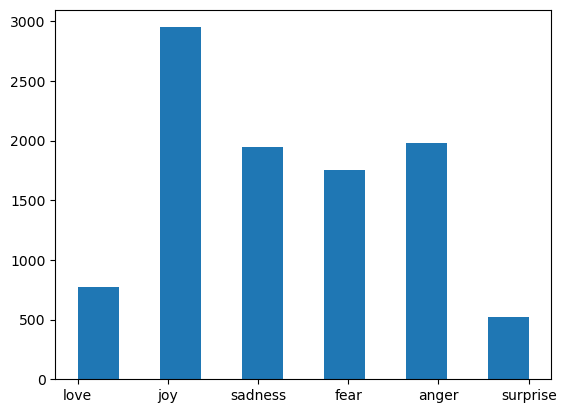

In [229]:
plt.hist(wfh_labels, bins=11)
plt.show()

In [290]:
print("love:", wfh_labels.count('love'))
print("joy:", wfh_labels.count('joy'))
print("sadness:", wfh_labels.count('sadness'))
print("fear:", wfh_labels.count('fear'))
print("anger:", wfh_labels.count('anger'))
print("surprise:", wfh_labels.count('surprise'))

love: 772
joy: 2949
sadness: 1942
fear: 1753
anger: 1978
surprise: 523


In [298]:
indexes = [i for i in range(len(wfh_labels)) if wfh_labels[i]=='joy']
for i in indexes:
    print(wfh_tweets[i])

much of the discussion surrounding the office sector has focused on work from home wfh policies driving employees
business support advisor f t ftc placesforpeople homebased remotework jobs adminjobs
new remote job senior data analyst go to market automation at block remotejobs remotework remote
new remote all other remote job lapieza backend developer python django apply here
frustrated with all the technology involved with home schooling your kids give us a call remotesupport
new remote job quickmail senior ruby on rails engineer days week remotework
remotework allows employees to work outside of an office people have the flexibility to design their days so th
bindusundaresan glengilmore kevin jackson attbusiness security success demands real balance
bindusundaresan glengilmore kevin jackson attbusiness security like an ace card always trumps
glengilmore kevin jackson attbusiness ransomware risk never goes away dez blanchfield sponsored
glengilmore tech change is like entropy it alway

how to start a career in real estate steps ryan serhant jobpreference jobs
homebusiness workfromhome this can be the simplest to build indefinite prospects information at this website
signs you need a reset let me help you get started reset guthealth rehydrate
new remote job website content editor wisevu remotejobs remoteworking workfromhome homejobs remotejob
cathie wood china already collapsed you just haven t seen it yet jobpreference jobs
want to make money freelancing this is how twitter linked in upwork fiver show ur work create head turning pos
the remote real estate agent outbound sales hiring now fort myers fl role is available to amazing candidates
by having less stuff i spend less time maintaining and taking care of stuff nooffice homeoffice workfromhome
by having less stuff i spend less time maintaining and taking care of stuff nooffice homeoffice workfromhome
medical coding jobs from home with lexicode get remote medical coding jobs medicalcoding medical coding
make fast c

In [301]:
import random
for a in range(0,5):
    i = random.randint(0, len(wfh_tweets) - 1)

    print('Tweet:', wfh_tweets[i])
    print('Predicted Emotion:', wfh_labels[i])
    print("\n")

Tweet: newly developed system generating life changing wealth currently looking for additional beta testers use this link
Predicted Emotion: love


Tweet: change management is an often overlooked skill but critical to your organization s success
Predicted Emotion: sadness


Tweet: if you have any skill then you can offer it online to make money here fiverr
Predicted Emotion: joy


Tweet: tuesday s tip of the week prevent your printer ink cartridges from drying out here s how remove your ink cart
Predicted Emotion: fear


Tweet: turn your cellphone into your personal atm text info to opportunity income workfromhome
Predicted Emotion: sadness




### References
1. https://www.analyticsvidhya.com/blog/2021/01/emotion-classification-on-twitter-data-using-transformers/
2. https://github.com/katoch99/Twitter-Emotion-Recognition/blob/main/Twitter%20Emotion%20Recognition%20using%20RNN.ipynb
3. https://www.kaggle.com/competitions/tweet-emotion-detection/code
4. https://michael-fuchs-python.netlify.app/2021/05/25/nlp-text-pre-processing-ii-tokenization-and-stop-words/
